Try to extract label information

In [16]:
from wavinfo import WavInfoReader
from utils.wav import read
import struct

path = '../data/audio/simpleCall/C_TR_Jt1_16_06_07_057.wav'
info = WavInfoReader(path)
info2 = read(path, True, True, True)
encoding = 'utf-8'

duration = info2[1].shape[0]/info2[0]
duration2 = info.data.byte_count / info.fmt.sample_rate

def sanatize_bytes(bytes):
	# first_null = next( (index for index, byte in enumerate(bytes) if byte == 0 ), None )
	# if first_null is not None:
	# 	trimmed = bytes[:first_null]
	# else:
	# 	trimmed = bytes

	decoded = bytes.decode(encoding)
	return decoded

with open(path, 'rb') as f:
	lblChunk = info._find_chunk_data(b'LBL ', f)

	s_datas = sanatize_bytes(lblChunk)
	data_list = s_datas.split("\r\n")
	data_list = [i.split("\t") for i in data_list]

D:\developement\python\project\bat_syllable_classifier\src\utils\wav.py:205: WavFileWarning: Chunk 'TIME' skipped
  warnings.warn("Chunk '" + chunk_id.decode('utf-8') + "' skipped", WavFileWarning)
D:\developement\python\project\bat_syllable_classifier\src\utils\wav.py:205: WavFileWarning: Chunk 'bext' skipped
  warnings.warn("Chunk '" + chunk_id.decode('utf-8') + "' skipped", WavFileWarning)
D:\developement\python\project\bat_syllable_classifier\src\utils\wav.py:205: WavFileWarning: Chunk 'LBL ' skipped
  warnings.warn("Chunk '" + chunk_id.decode('utf-8') + "' skipped", WavFileWarning)


Calculate sets

In [ ]:
import pandas as pd
from matplotlib import pyplot

pyplot.style.use('dark_background')

full_df = pd.read_excel(r'../data/tmp/Vermessene_Sil_Babbeln_2020.xlsx', sheet_name=None)

df = pd.DataFrame()
for name, sheet in full_df.items():
    sheet['sheet'] = name
    sheet = sheet.rename(columns=lambda x: x.split('\n')[-1])
    df = df.append(sheet[['syllable_type', 'duration']])

df.reset_index(inplace=True, drop=True)

stats = df.groupby(by='syllable_type').agg({'min', 'max', 'mean', 'median', 'std', 'count'})
# droplevel(): removes the column level "duration" because of groupBy -> (duration, min), (duration, max) ....
# reset_index() helps to create a realisation of the groupBy?
stats = pd.DataFrame(stats.reset_index()).droplevel(0, axis=1)
stats.rename(columns={ stats.columns[0]: "syllable_type" }, inplace = True)
index = stats['syllable_type'].tolist()
stats.sort_values(by='median', ascending=True, inplace=True)
print(stats[['syllable_type', 'mean', 'median', 'std', 'min', 'max', 'count']])
sorted_index = df.groupby(by='syllable_type').median().sort_values(by='duration').index.values
sorted_index_map = {v:i for i,v in enumerate(sorted_index)}

positions = list()
for v in index:
	positions.append(sorted_index_map[v])

boxplot = df.boxplot(
	by='syllable_type'
	, figsize=(20.0, 10.0)
	, color=dict(boxes='r', whiskers='r', medians='r', caps='r')
	, positions=positions
)
pyplot.show()


Visualize how the labels occur over a time

In [ ]:
from pandas import DataFrame
from matplotlib import pyplot
from engine.metadata import metadata_db
import datetime

pyplot.style.use('dark_background')

numSeq = 0
sequenceMeta = dict()
mdb = metadata_db('metadata.json')
minTime = 99999999999
maxTime = 0

for stem in mdb.db:
	entry = mdb.db[stem]
	time = datetime.datetime.strptime(entry.date + ' ' + entry.time, '%Y-%m-%d %H:%M:%S').timestamp()
	minTime = min(minTime, time)
	maxTime = max(maxTime, time)

	seqCounts = dict()

	for peak in entry.peaks:
		numSeq = numSeq + 1
		s = peak['sequence']

		if s not in seqCounts:
			seqCounts[s] = 0
		seqCounts[s] += 1

	sequenceMeta[time] = seqCounts

sortedData = dict()
for time in sorted(sequenceMeta):
	sortedData[datetime.datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S')] = sequenceMeta[time]

data = DataFrame.from_dict(sortedData, orient='index')
data = data.sort_index()
data.plot(kind='bar', subplots=True, legend=False, ylim=(0,700), figsize=(10.0, 30.0))
pyplot.show()


Index(['file', 'syllable_type', 'duration'], dtype='object')
  syllable_type      mean  median       std    min    max  count
4           VSV  0.042810   0.044  0.006047  0.031  0.054     21
2            B4  0.061198   0.059  0.015155  0.037  0.093     91
3           UPS  0.065307   0.064  0.011412  0.038  0.106    461
0            B2  0.079165   0.070  0.032175  0.033  0.220    310
1            B3  0.074685   0.073  0.017777  0.047  0.141    124


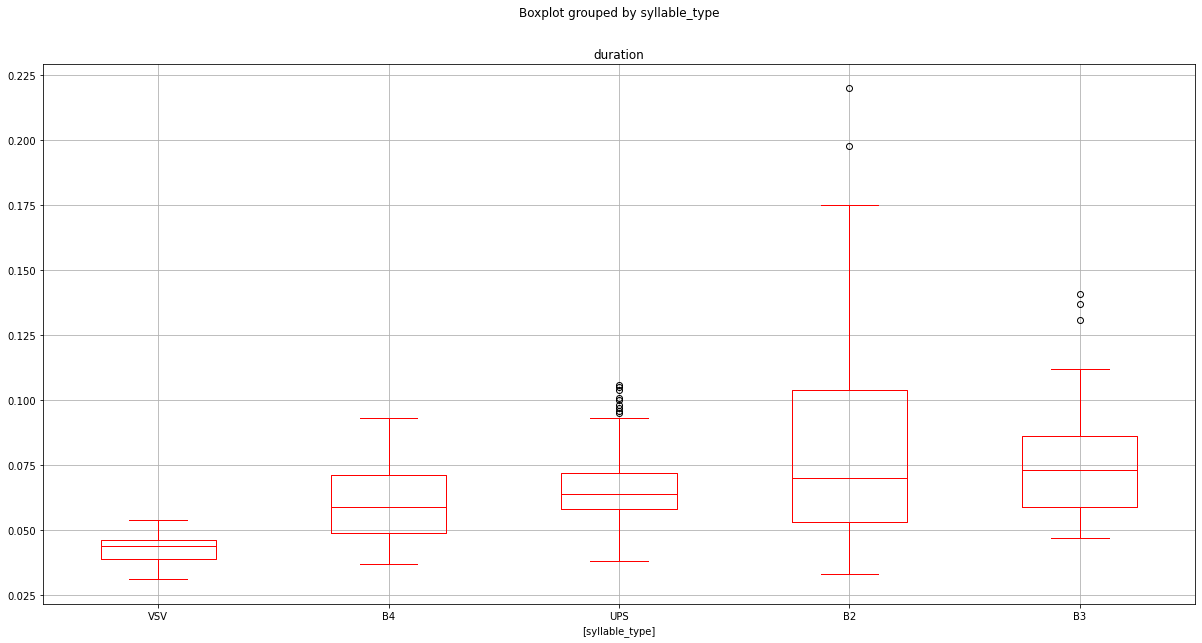

In [40]:
import csv, ntpath
from engine.settings import  FILES_FOLDER
from engine.utils import list_files
from utils.wav import read
import pandas as pd
from matplotlib import pyplot

source = 'simple_call_1/audio'
csv_file = '../data/simple_call_1/durations.csv'
files = [FILES_FOLDER / f"{source}/{f}" for f in list_files(f"{FILES_FOLDER}/{source}")]

with open(csv_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=['file', 'syllable_type', 'duration'])
    writer.writeheader()

    for file in files:
        info2 = read(file, True, True, True)
        encoding = 'utf-8'
        duration = info2[1].shape[0]/info2[0]
        file_name = ntpath.basename(file)
        syllable_type = file_name.split('_')[-1][0:-4]
        if syllable_type in ['B2', 'B3', 'B4', 'VSV', 'UPS']:
            writer.writerow({'file':file_name, 'syllable_type':syllable_type, 'duration':duration})


df = pd.read_csv(csv_file, sep=',')
print(df.columns)
stats = df.groupby(by='syllable_type').agg({'min', 'max', 'mean', 'median', 'std', 'count'})
# droplevel(): removes the column level "duration" because of groupBy -> (duration, min), (duration, max) ....
# reset_index() helps to create a realisation of the groupBy?
stats = pd.DataFrame(stats.reset_index()).droplevel(0, axis=1)
stats.rename(columns={ stats.columns[0]: "syllable_type" }, inplace = True)
index = stats['syllable_type'].tolist()
stats.sort_values(by='median', ascending=True, inplace=True)
print(stats[['syllable_type', 'mean', 'median', 'std', 'min', 'max', 'count']])
sorted_index = df.groupby(by='syllable_type').median().sort_values(by='duration').index.values
sorted_index_map = {v:i for i,v in enumerate(sorted_index)}

positions = list()
for v in index:
	positions.append(sorted_index_map[v])

boxplot = df.boxplot(
	by='syllable_type'
	, figsize=(20.0, 10.0)
	, color=dict(boxes='r', whiskers='r', medians='r', caps='r')
	, positions=positions
)
pyplot.show()